In [ ]:
from google.colab import files
files.upload()  # upload the kaggle.json file for API token


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rodrigogarciaortegon","key":"bbc574d9416135ce32660ff1d416dbbe"}'}

In [ ]:
!pip install --quiet kaggle
# Make directory and move Kaggle token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the GTSRB dataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# Unzip into a folder
!unzip -q gtsrb-german-traffic-sign.zip -d gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 85% 523M/612M [00:00<00:00, 1.37GB/s]
100% 612M/612M [00:00<00:00, 1.37GB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os


import cv2
from PIL import Image


import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [ ]:
# Load GTSRB into arrays
data = []
labels = []
num_classes = 43

# Path to the unzipped folder
base_path = os.path.join(os.getcwd(), 'gtsrb-german-traffic-sign')
train_path = os.path.join(base_path, 'Train')

for class_id in range(num_classes):
    class_dir = os.path.join(train_path, str(class_id))
    if not os.path.isdir(class_dir):
        continue

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            # open, resize, convert to array
            img = Image.open(img_path)
            img = img.resize((30, 30))
            img = np.array(img)
            data.append(img)
            labels.append(class_id)
        except Exception as e:
            # skip unreadable files
            print(f"Skipping {img_path}: {e}")

# Numpy arrays
data = np.array(data)
labels = np.array(labels)

# Normalize pixel values to [0,1]
data = data.astype('float32') / 255.0

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val,   num_classes)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)


Training set: (31367, 30, 30, 3) (31367, 43)
Validation set: (7842, 30, 30, 3) (7842, 43)


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.3933 - loss: 2.2311 - val_accuracy: 0.9574 - val_loss: 0.1537
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9132 - loss: 0.2865 - val_accuracy: 0.9795 - val_loss: 0.0792
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9537 - loss: 0.1527 - val_accuracy: 0.9853 - val_loss: 0.0486
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9633 - loss: 0.1245 - val_accuracy: 0.9901 - val_loss: 0.0367
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9696 - loss: 0.0981 - val_accuracy: 0.9907 - val_loss: 0.0358
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9717 - loss: 0.0858 - val_accuracy: 0.9912 - val_loss: 0.0311
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9771 - loss: 0.0781 - val_accuracy: 0.9904 - val_loss: 0.0348
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9797 - loss: 0.0683 - val_accuracy: 

Text(0.5, 0, 'epoch')

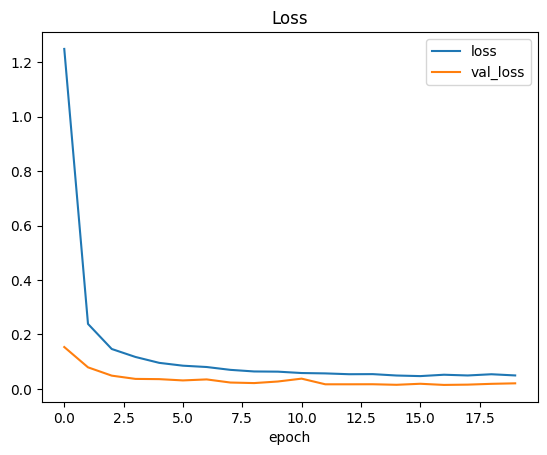

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

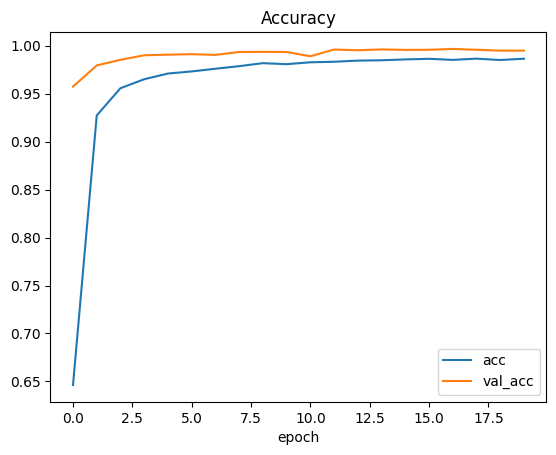

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.metrics import accuracy_score

# Point at the base folder
base_path  = os.path.join(os.getcwd(), 'gtsrb-german-traffic-sign')
test_csv   = os.path.join(base_path, 'Test.csv')
test_df    = pd.read_csv(test_csv)

# Grab true labels and relative paths
y_true     = test_df['ClassId'].values
test_paths = test_df['Path'].values  # e.g. 'Test/00000.ppm'

# Load & preprocess images
data = []
for rel_path in test_paths:
    img_path = os.path.join(base_path, rel_path)
    img      = Image.open(img_path).resize((30, 30))
    data.append(np.array(img))
X_test = np.array(data, dtype='float32') / 255.0

# Run inference
pred_probs = model.predict(X_test, verbose=1)
y_pred     = np.argmax(pred_probs, axis=1)

# Final accuracy
print(f"Test set accuracy: {accuracy_score(y_true, y_pred):.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Test set accuracy: 0.9679


In [ ]:
# Save the model to HDF5
model.save('gtsrb_traffic_sign_model.h5')
print("Model saved as gtsrb_traffic_sign_model.h5")

# Download the .h5 file to your computer
from google.colab import files
files.download('gtsrb_traffic_sign_model.h5')


Model saved as gtsrb_traffic_sign_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>